In [170]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

import gd as gd
import math
from random import randint
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from scipy.io.arff import loadarff

In [171]:
DEVIATION_BITS = 2
DATA = "data/Glass/Glass_withoutdupl_norm.arff"
COLUMNS = ['A', 'B']
SAMPLE_SIZE = 100
MULTIPLIER = 100
MAX_ERROR_MARGIN = 0

data = loadarff(DATA)
df = pd.DataFrame(data[0])
df = df.rename(columns={'var_0000': 'A', 'var_0001': 'B', 'var_0002': 'C', 'var_0003': 'D', 'var_0004': 'E', 'var_0005': 'F', 'var_0006': 'G'})

y = pd.Series(np.where(df.outlier.values == b'yes', -1, 1),
          df.index)
X = df[COLUMNS]
X_int = X * MULTIPLIER
X_int.head()

,A,B
0,46.7651,32.1584
1,49.6412,22.0491
2,51.9133,40.4464
3,19.9650,54.7373
4,84.7261,28.6361


## Perform Generalized Deduplication

<AxesSubplot:ylabel='Density'>

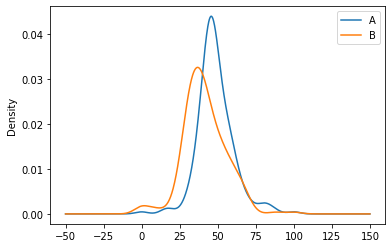

In [172]:
X_bases = X_int.apply(lambda x: gd.compress_int_array(x, deviation_bits=DEVIATION_BITS, output="integer"), axis = 1)
X_bases = pd.DataFrame(pd.DataFrame(X_bases)[0].to_list(), columns=COLUMNS)
X_bases.plot.density()

## Isolation Forest

In [173]:
rng = np.random.RandomState(42)

outliers = y.where(lambda x: x == -1).dropna()
outlier_indices = outliers.index
X_outliers = X_bases.filter(items=outlier_indices, axis=0)
X_outliers = np.array(X_outliers)

X = np.array(X_bases)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rng)

clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
dec_function = clf.decision_function(X_train)
pd.concat([pd.DataFrame(X_train),pd.DataFrame(dec_function)], axis=1)

,0,1,0
0,40,28,0.064409
1,48,40,0.135980
2,48,36,0.131780
3,64,60,-0.025713
4,48,48,0.085843
...,...,...,...
138,48,36,0.131780
139,52,36,0.089972
140,56,36,0.047334
141,32,56,0.006541


In [174]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
confusion_matrix(y_test, y_pred_test)

array([[ 0,  1],
       [18, 52]])

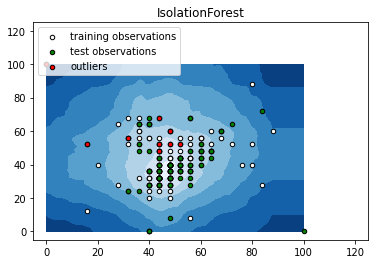

In [175]:

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(0, 100, 50), np.linspace(0, 100, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")

plt.axis("tight")
plt.xlim((-5, 125))
plt.ylim((-5, 125))
plt.legend(
    [b1, b2, c],
    ["training observations", "test observations", "outliers"],
    loc="upper left",)
plt.show()